In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('data/ml-ready/final/population-projection-ml-ready.csv')

In [2]:
df.keys()


Index(['Year', 'Population', 'White Alone', 'Hispanic/Latino',
       'Black or African American Alone', 'Asian/Pacific Islander',
       'Some Other Race Alone'],
      dtype='object')

In [3]:
df

,Year,Population,White Alone,Hispanic/Latino,Black or African American Alone,Asian/Pacific Islander,Some Other Race Alone
0,2022,6.72270,0.094200,0.415600,0.007800,0.000300,0.104200
1,2021,6.72550,0.113500,0.400900,0.007700,0.001200,0.099600
2,2020,6.58620,0.120300,0.373800,0.006800,0.000900,0.094300
3,2019,6.59680,0.126600,0.353100,0.009500,0.001000,0.102900
4,2018,6.59890,0.117300,0.351800,0.009500,0.000900,0.109300
5,2017,6.59460,0.111800,0.342400,0.008800,0.001000,0.113900
6,2016,6.59100,0.115300,0.333100,0.011900,0.000500,0.106600
7,2015,6.59030,0.117000,0.320000,0.012600,0.000700,0.113400
8,2014,6.58830,0.116600,0.314300,0.010600,0.001500,0.115900
9,2025,6.71269,3.881949,1.323742,0.849155,0.438339,0.219505


In [49]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# # Load your dataset
# df = pd.read_csv('data/ml-ready/dailyData.csv')
# # print(df)

# Preprocess the data
# features = df.drop(columns=['Date Local','Units of Measure','Arithmetic Mean','1st Max Value','1st Max Hour','AQI','State Name','County Name','AQI']).values
# target = df['AQI'].values
df['AQI'] = 0

# Preprocess the data
features = df.drop(columns=['Year', 'AQI']).values

target = df['AQI'].values

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

def create_test_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 8  # Use the same sequence length as used in training
test_sequences = create_test_sequences(features_scaled, sequence_length)

# Convert to PyTorch tensors
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)

# Define the CNN-LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=test_sequences.shape[2], out_channels=64, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=100, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_features, sequence_length)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, sequence_length, num_features)
        x, (hn, cn) = self.lstm1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = CNN_LSTM()

In [50]:
# Function to load the model
def load_model(filepath):
    model = CNN_LSTM()
    model.load_state_dict(torch.load(filepath))
    return model

# Load the saved model (example usage)
loaded_model = load_model('best_model.pth')

In [51]:
test_sequences.shape

torch.Size([6, 8, 6])

In [52]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(test_sequences).squeeze().numpy()

print(predictions)

print("Predicted AQI values:", predictions)

[ 34.978386  37.343136  34.649597 118.8167   127.37822  126.6402  ]
Predicted AQI values: [ 34.978386  37.343136  34.649597 118.8167   127.37822  126.6402  ]


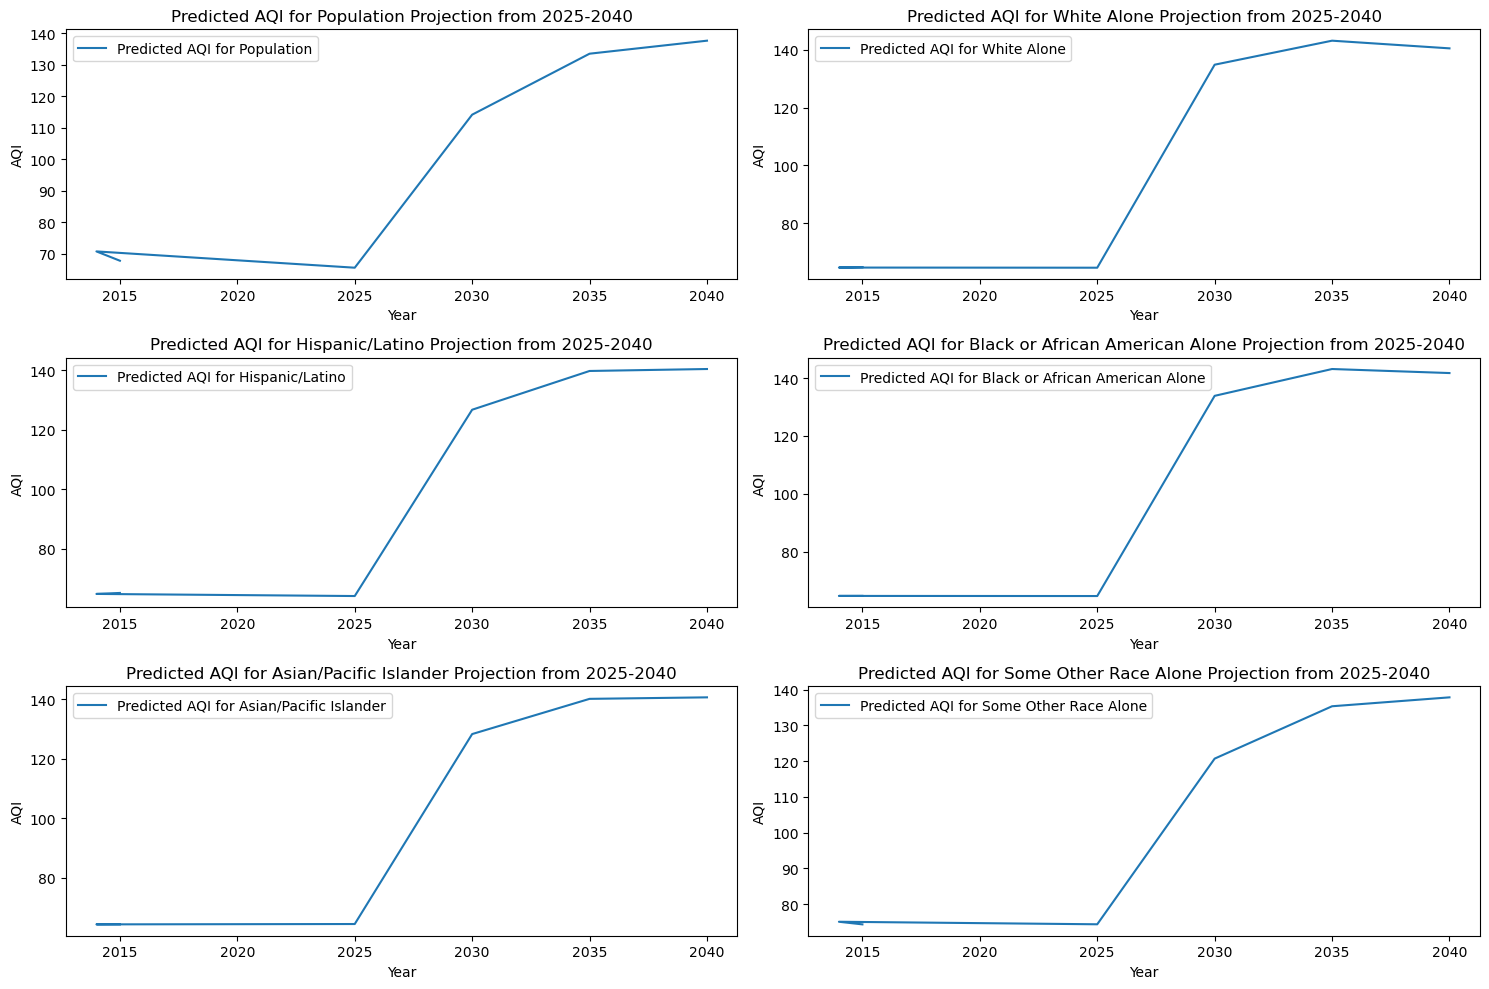

In [53]:
# Analyze results for different racial population communities
racial_groups = ['Population', 'White Alone', 'Hispanic/Latino', 'Black or African American Alone',
       'Asian/Pacific Islander', 'Some Other Race Alone']  # Replace with actual column names
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, group in enumerate(racial_groups):
    group_features = df[[group]].values
    group_scaler = MinMaxScaler()
    group_features_scaled = group_scaler.fit_transform(group_features)
    
    # Duplicate the single feature to match the input channels expected by the model
    group_features_scaled = np.repeat(group_features_scaled, repeats=test_sequences.shape[2], axis=1)
    
    # Create sequences for the duplicated features and corresponding years
    group_features_seq = []
    group_years_seq = []
    for i in range(len(group_features_scaled) - sequence_length + 1):
        group_features_seq.append(group_features_scaled[i:i + sequence_length])
        group_years_seq.append(df['Year'].values[i + sequence_length - 1])
    group_features_seq = np.array(group_features_seq)
    
    group_features_seq = torch.tensor(group_features_seq, dtype=torch.float32)
    
    model.eval()
    group_predictions = []
    with torch.no_grad():
        for batch in group_features_seq:
            batch = batch.unsqueeze(0)  # Add batch dimension
            outputs = model(batch)
            group_predictions.extend(outputs.tolist())
    
    group_predictions = np.array(group_predictions)

    # Plotting in the corresponding subplot
    ax = axes[idx]
    ax.plot(group_years_seq, group_predictions, label=f'Predicted AQI for {group}')
    ax.set_xlabel('Year')
    ax.set_ylabel('AQI')
    ax.set_title(f'Predicted AQI for {group} Projection from 2025-2040')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()